# This new ML pipeline enables equal representation of each polarization state in each train, test, and validation dataset
### In the future, if needed, refactor into functions for efficiency

In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns

In [105]:
from core.getdata import *
from core.dataset import *
from core.network import *
from core.trainer import *
from core.visualization import *

In [4]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

In [5]:
ligands = ["TNF", "R84", "PIC", "P3K", "FLA", "CpG", "FSL", "LPS", "UST"]
polarization = ["", "ib", "ig", "i0", "i3", "i4"]
replicas, size = 2, 1288 # replicated

In [ ]:
asd = DatasetPolar(ligands, polarization, replicas, size)

In [18]:
asd.labels.shape

(69552,)

In [6]:
m0 = DatasetPolar(ligands, [""], replicas, size)
ib = DatasetPolar(ligands, ["ib"], replicas, size)
ig = DatasetPolar(ligands, ["ig"], replicas, size)
i0 = DatasetPolar(ligands, ["i0"], replicas, size)
i3 = DatasetPolar(ligands, ["i3"], replicas, size)
i4 = DatasetPolar(ligands, ["i4"], replicas, size)

In [7]:
print(len(m0), len(ib), len(ig), len(i0), len(i3), len(i4))

11592 11592 11592 11592 11592 11592


In [73]:
m0_train, m0_val, m0_test = torch.utils.data.random_split(m0, [6956, 2318, 2318])
ib_train, ib_val, ib_test = torch.utils.data.random_split(ib, [6956, 2318, 2318])
ig_train, ig_val, ig_test = torch.utils.data.random_split(ig, [6956, 2318, 2318])
i0_train, i0_val, i0_test = torch.utils.data.random_split(i0, [6956, 2318, 2318])
i3_train, i3_val, i3_test = torch.utils.data.random_split(i3, [6956, 2318, 2318])
i4_train, i4_val, i4_test = torch.utils.data.random_split(i4, [6956, 2318, 2318])

In [74]:
# extract all data and labels from each torch subset object and refactor into my own objects

def extract_xy(subsets):
    train, val, test = subsets # unpack tuple
    train_X = [item[0] for item in train]
    train_Y = [item[1] for item in train]
    val_X = [item[0] for item in val]
    val_Y = [item[1] for item in val]
    test_X = [item[0] for item in test]
    test_Y = [item[1] for item in test]
    
    return train_X, train_Y, val_X, val_Y, test_X, test_Y

In [75]:
m0_train_X, m0_train_Y, m0_val_X, m0_val_Y, m0_test_X, m0_test_Y = extract_xy((m0_train, m0_val, m0_test))
ib_train_X, ib_train_Y, ib_val_X, ib_val_Y, ib_test_X, ib_test_Y = extract_xy((ib_train, ib_val, ib_test))
ig_train_X, ig_train_Y, ig_val_X, ig_val_Y, ig_test_X, ig_test_Y = extract_xy((ig_train, ig_val, ig_test))
i0_train_X, i0_train_Y, i0_val_X, i0_val_Y, i0_test_X, i0_test_Y = extract_xy((i0_train, i0_val, i0_test))
i3_train_X, i3_train_Y, i3_val_X, i3_val_Y, i3_test_X, i3_test_Y = extract_xy((i3_train, i3_val, i3_test))
i4_train_X, i4_train_Y, i4_val_X, i4_val_Y, i4_test_X, i4_test_Y = extract_xy((i4_train, i4_val, i4_test))

In [76]:
# split into 60/20/20 for each polarization dataset
# more empirical method to analyze model metrics across each polarization

# X = np.vstack([m0.data, ib.data, ig.data, i0.data, i3.data, i4.data])
# Y = np.hstack([m0.labels, ib.labels, ig.labels, i0.labels, i3.labels, i4.labels])

In [77]:
class TorchData:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [86]:
# need to concat all train_X and train_Y into one dataset for training
train_X = np.vstack([m0_train_X, ib_train_X, ig_train_X, i0_train_X, i3_train_X, i4_train_X])
train_Y = np.hstack([m0_train_Y, ib_train_Y, ig_train_Y, i0_train_Y, i3_train_Y, i4_train_Y])

val_X = np.vstack([m0_val_X, ib_val_X, ig_val_X, i0_val_X, i3_val_X, i4_val_X])
val_Y = np.hstack([m0_val_Y, ib_val_Y, ig_val_Y, i0_val_Y, i3_val_Y, i4_val_Y])

test_X = np.vstack([m0_test_X, ib_test_X, ig_test_X, i0_test_X, i3_test_X, i4_test_X])
test_Y = np.hstack([m0_test_Y, ib_test_Y, ig_test_Y, i0_test_Y, i3_test_Y, i4_test_Y])

In [87]:
print(train_X.shape, train_Y.shape)
print(val_X.shape, val_Y.shape)
print(test_X.shape, test_Y.shape)

(41736, 98, 1) (41736,)
(13908, 98, 1) (13908,)
(13908, 98, 1) (13908,)


In [88]:
train = TorchData(train_X, train_Y)
val = TorchData(val_X, val_Y)
test = TorchData(test_X, test_Y)

In [89]:
trainloader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=True)

In [90]:
# hyperparameters
input_size = 1
hidden_size = 98
output_size = 9

lr = 0.001
n_epochs = 70
batch_size = 64
device = torch.device('cuda')

In [91]:
net = LSTM(input_size=input_size, hidden_sizes=hidden_size, output_size=output_size, num_layers=1, device=device)

In [92]:
net.train()

LSTM(
  (lstm): LSTM(1, 98, batch_first=True)
  (fc1): Linear(in_features=98, out_features=9, bias=True)
)

In [93]:
trainer = LSTMTrainer(model=net, device=device)

In [94]:
trainer.train(trainloader, valloader, batch_size=batch_size, n_epochs=n_epochs)

  1%|█▏                                                                                 | 1/70 [00:03<04:28,  3.89s/it]

Epoch 001: | Training Loss: 2.1381595277129053 | Validation Loss: 2.084531136062167


  3%|██▎                                                                                | 2/70 [00:07<04:14,  3.74s/it]

Epoch 002: | Training Loss: 2.0839452851238516 | Validation Loss: 2.018390776914194


  4%|███▌                                                                               | 3/70 [00:11<04:07,  3.69s/it]

Epoch 003: | Training Loss: 1.9340957985537706 | Validation Loss: 1.8499932841423454


  6%|████▋                                                                              | 4/70 [00:15<04:07,  3.75s/it]

Epoch 004: | Training Loss: 1.843776519776851 | Validation Loss: 1.8075129422572775


  7%|█████▉                                                                             | 5/70 [00:18<04:04,  3.76s/it]

Epoch 005: | Training Loss: 1.791275236727085 | Validation Loss: 1.7725394931408243


  9%|███████                                                                            | 6/70 [00:22<03:57,  3.70s/it]

Epoch 006: | Training Loss: 1.7602377574987835 | Validation Loss: 1.7465311523971208


 10%|████████▎                                                                          | 7/70 [00:25<03:50,  3.66s/it]

Epoch 007: | Training Loss: 1.7190026714827347 | Validation Loss: 1.7307657697878847


 11%|█████████▍                                                                         | 8/70 [00:29<03:47,  3.67s/it]

Epoch 008: | Training Loss: 1.6841830502607922 | Validation Loss: 1.696201930899139


 13%|██████████▋                                                                        | 9/70 [00:33<03:43,  3.66s/it]

Epoch 009: | Training Loss: 1.6463491852761776 | Validation Loss: 1.6357282257955008


 14%|███████████▋                                                                      | 10/70 [00:36<03:38,  3.65s/it]

Epoch 010: | Training Loss: 1.6108130640129217 | Validation Loss: 1.6061057869447481


 16%|████████████▉                                                                     | 11/70 [00:40<03:34,  3.64s/it]

Epoch 011: | Training Loss: 1.589905130552844 | Validation Loss: 1.5749797022670782


 17%|██████████████                                                                    | 12/70 [00:44<03:31,  3.65s/it]

Epoch 012: | Training Loss: 1.6136956830119649 | Validation Loss: 1.783746145187168


 19%|███████████████▏                                                                  | 13/70 [00:47<03:28,  3.65s/it]

Epoch 013: | Training Loss: 1.6519996486433066 | Validation Loss: 1.6223221464988289


 20%|████████████████▍                                                                 | 14/70 [00:51<03:24,  3.65s/it]

Epoch 014: | Training Loss: 1.5842738025586418 | Validation Loss: 1.5965178947929943


 21%|█████████████████▌                                                                | 15/70 [00:55<03:21,  3.66s/it]

Epoch 015: | Training Loss: 1.5546158508356278 | Validation Loss: 1.5486857065367043


 23%|██████████████████▋                                                               | 16/70 [00:58<03:19,  3.70s/it]

Epoch 016: | Training Loss: 1.5351986839431715 | Validation Loss: 1.5369754231304205


 24%|███████████████████▉                                                              | 17/70 [01:02<03:17,  3.72s/it]

Epoch 017: | Training Loss: 1.5206508358988973 | Validation Loss: 1.5249513458768162


 26%|█████████████████████                                                             | 18/70 [01:06<03:12,  3.70s/it]

Epoch 018: | Training Loss: 1.5085518079001177 | Validation Loss: 1.5135509612363414


 27%|██████████████████████▎                                                           | 19/70 [01:10<03:07,  3.67s/it]

Epoch 019: | Training Loss: 1.4931938620840426 | Validation Loss: 1.4948634106084842


 29%|███████████████████████▍                                                          | 20/70 [01:13<03:02,  3.64s/it]

Epoch 020: | Training Loss: 1.4804053423415646 | Validation Loss: 1.4811759859050087


 30%|████████████████████████▌                                                         | 21/70 [01:17<02:57,  3.63s/it]

Epoch 021: | Training Loss: 1.467680844194491 | Validation Loss: 1.4713993203749351


 31%|█████████████████████████▊                                                        | 22/70 [01:20<02:54,  3.64s/it]

Epoch 022: | Training Loss: 1.4537726604190027 | Validation Loss: 1.4603185095918287


 33%|██████████████████████████▉                                                       | 23/70 [01:24<02:50,  3.64s/it]

Epoch 023: | Training Loss: 1.435422400055399 | Validation Loss: 1.4735981242372356


 34%|████████████████████████████                                                      | 24/70 [01:28<02:47,  3.63s/it]

Epoch 024: | Training Loss: 1.4194377698175393 | Validation Loss: 1.4439951072045423


 36%|█████████████████████████████▎                                                    | 25/70 [01:31<02:45,  3.69s/it]

Epoch 025: | Training Loss: 1.4028335281207038 | Validation Loss: 1.4428186695510095


 37%|██████████████████████████████▍                                                   | 26/70 [01:35<02:42,  3.68s/it]

Epoch 026: | Training Loss: 1.389726441176708 | Validation Loss: 1.418231175580156


 39%|███████████████████████████████▋                                                  | 27/70 [01:39<02:38,  3.68s/it]

Epoch 027: | Training Loss: 1.386302241505014 | Validation Loss: 1.4175333878315917


 40%|████████████████████████████████▊                                                 | 28/70 [01:42<02:34,  3.67s/it]

Epoch 028: | Training Loss: 1.359609809348996 | Validation Loss: 1.4104894049670718


 41%|█████████████████████████████████▉                                                | 29/70 [01:46<02:29,  3.65s/it]

Epoch 029: | Training Loss: 1.3576585937057484 | Validation Loss: 1.3927533353140595


 43%|███████████████████████████████████▏                                              | 30/70 [01:50<02:25,  3.64s/it]

Epoch 030: | Training Loss: 1.3495887914989115 | Validation Loss: 1.3844629233583399


 44%|████████████████████████████████████▎                                             | 31/70 [01:53<02:22,  3.66s/it]

Epoch 031: | Training Loss: 1.3298397581756207 | Validation Loss: 1.417706005890435


 46%|█████████████████████████████████████▍                                            | 32/70 [01:57<02:21,  3.72s/it]

Epoch 032: | Training Loss: 1.3223412715092553 | Validation Loss: 1.377878297906403


 47%|██████████████████████████████████████▋                                           | 33/70 [02:01<02:18,  3.74s/it]

Epoch 033: | Training Loss: 1.319492099204801 | Validation Loss: 1.403743312993181


 49%|███████████████████████████████████████▊                                          | 34/70 [02:05<02:14,  3.74s/it]

Epoch 034: | Training Loss: 1.3053355497203962 | Validation Loss: 1.3509326019418348


 50%|█████████████████████████████████████████                                         | 35/70 [02:08<02:09,  3.70s/it]

Epoch 035: | Training Loss: 1.293840114318211 | Validation Loss: 1.35520200554384


 51%|██████████████████████████████████████████▏                                       | 36/70 [02:12<02:04,  3.67s/it]

Epoch 036: | Training Loss: 1.280405313004761 | Validation Loss: 1.354522938028388


 53%|███████████████████████████████████████████▎                                      | 37/70 [02:16<02:00,  3.66s/it]

Epoch 037: | Training Loss: 1.2755721473401758 | Validation Loss: 1.3277970858670156


 54%|████████████████████████████████████████████▌                                     | 38/70 [02:19<01:57,  3.67s/it]

Epoch 038: | Training Loss: 1.2682257082889492 | Validation Loss: 1.3292256642919067


 56%|█████████████████████████████████████████████▋                                    | 39/70 [02:23<01:53,  3.66s/it]

Epoch 039: | Training Loss: 1.255596977737012 | Validation Loss: 1.3277369650132065


 57%|██████████████████████████████████████████████▊                                   | 40/70 [02:27<01:50,  3.69s/it]

Epoch 040: | Training Loss: 1.2559039862926302 | Validation Loss: 1.3097764986370681


 59%|████████████████████████████████████████████████                                  | 41/70 [02:30<01:46,  3.69s/it]

Epoch 041: | Training Loss: 1.2444771645080075 | Validation Loss: 1.3095270996793695


 60%|█████████████████████████████████████████████████▏                                | 42/70 [02:34<01:44,  3.72s/it]

Epoch 042: | Training Loss: 1.2356501342143984 | Validation Loss: 1.3124596041823746


 61%|██████████████████████████████████████████████████▎                               | 43/70 [02:38<01:40,  3.71s/it]

Epoch 043: | Training Loss: 1.2333688237583107 | Validation Loss: 1.3205759897144562


 63%|███████████████████████████████████████████████████▌                              | 44/70 [02:41<01:36,  3.70s/it]

Epoch 044: | Training Loss: 1.2239312125201611 | Validation Loss: 1.3250580823749578


 64%|████████████████████████████████████████████████████▋                             | 45/70 [02:45<01:32,  3.69s/it]

Epoch 045: | Training Loss: 1.2118414704321354 | Validation Loss: 1.3030294480673763


 66%|█████████████████████████████████████████████████████▉                            | 46/70 [02:49<01:29,  3.73s/it]

Epoch 046: | Training Loss: 1.2152666128247658 | Validation Loss: 1.3073940848538634


 67%|███████████████████████████████████████████████████████                           | 47/70 [02:53<01:25,  3.73s/it]

Epoch 047: | Training Loss: 1.2038378396041542 | Validation Loss: 1.2855906382613225


 69%|████████████████████████████████████████████████████████▏                         | 48/70 [02:56<01:21,  3.71s/it]

Epoch 048: | Training Loss: 1.1829466360633991 | Validation Loss: 1.2885876396380433


 70%|█████████████████████████████████████████████████████████▍                        | 49/70 [03:00<01:17,  3.68s/it]

Epoch 049: | Training Loss: 1.1838863773148787 | Validation Loss: 1.2688148710705818


 71%|██████████████████████████████████████████████████████████▌                       | 50/70 [03:04<01:13,  3.66s/it]

Epoch 050: | Training Loss: 1.1711111133533085 | Validation Loss: 1.28333085474618


 73%|███████████████████████████████████████████████████████████▋                      | 51/70 [03:07<01:09,  3.65s/it]

Epoch 051: | Training Loss: 1.1649478668458246 | Validation Loss: 1.2617055226903442


 74%|████████████████████████████████████████████████████████████▉                     | 52/70 [03:11<01:06,  3.71s/it]

Epoch 052: | Training Loss: 1.1608550418025685 | Validation Loss: 1.2731236457277875


 76%|██████████████████████████████████████████████████████████████                    | 53/70 [03:15<01:03,  3.74s/it]

Epoch 053: | Training Loss: 1.1375706947963418 | Validation Loss: 1.2556681780640138


 77%|███████████████████████████████████████████████████████████████▎                  | 54/70 [03:19<00:59,  3.75s/it]

Epoch 054: | Training Loss: 1.1410677991636313 | Validation Loss: 1.278840211553311


 79%|████████████████████████████████████████████████████████████████▍                 | 55/70 [03:23<00:56,  3.79s/it]

Epoch 055: | Training Loss: 1.1363413430647682 | Validation Loss: 1.257238283890103


 80%|█████████████████████████████████████████████████████████████████▌                | 56/70 [03:26<00:53,  3.79s/it]

Epoch 056: | Training Loss: 1.1328874636572681 | Validation Loss: 1.2424779457783481


 81%|██████████████████████████████████████████████████████████████████▊               | 57/70 [03:30<00:48,  3.74s/it]

Epoch 057: | Training Loss: 1.2567164705321763 | Validation Loss: 1.5648780700263627


 83%|███████████████████████████████████████████████████████████████████▉              | 58/70 [03:34<00:44,  3.70s/it]

Epoch 058: | Training Loss: 1.448244552243541 | Validation Loss: 1.4333528914582838


 84%|█████████████████████████████████████████████████████████████████████             | 59/70 [03:37<00:40,  3.68s/it]

Epoch 059: | Training Loss: 1.2941500033390285 | Validation Loss: 1.33724687241633


 86%|██████████████████████████████████████████████████████████████████████▎           | 60/70 [03:41<00:36,  3.67s/it]

Epoch 060: | Training Loss: 1.2397325862239001 | Validation Loss: 1.324400290436701


 87%|███████████████████████████████████████████████████████████████████████▍          | 61/70 [03:44<00:32,  3.66s/it]

Epoch 061: | Training Loss: 1.1913739116962252 | Validation Loss: 1.2904456246883498


 89%|████████████████████████████████████████████████████████████████████████▋         | 62/70 [03:48<00:29,  3.65s/it]

Epoch 062: | Training Loss: 1.1689429749573537 | Validation Loss: 1.2804027883284683


 90%|█████████████████████████████████████████████████████████████████████████▊        | 63/70 [03:52<00:25,  3.65s/it]

Epoch 063: | Training Loss: 1.1547332907161159 | Validation Loss: 1.265180704517102


 91%|██████████████████████████████████████████████████████████████████████████▉       | 64/70 [03:55<00:21,  3.64s/it]

Epoch 064: | Training Loss: 1.141061222754065 | Validation Loss: 1.2819082102644335


 93%|████████████████████████████████████████████████████████████████████████████▏     | 65/70 [03:59<00:18,  3.64s/it]

Epoch 065: | Training Loss: 1.14046675322797 | Validation Loss: 1.2633431570245586


 94%|█████████████████████████████████████████████████████████████████████████████▎    | 66/70 [04:03<00:14,  3.64s/it]

Epoch 066: | Training Loss: 1.1291932480076006 | Validation Loss: 1.2592746016629246


 96%|██████████████████████████████████████████████████████████████████████████████▍   | 67/70 [04:06<00:10,  3.63s/it]

Epoch 067: | Training Loss: 1.1295023649063811 | Validation Loss: 1.2591669638769343


 97%|███████████████████████████████████████████████████████████████████████████████▋  | 68/70 [04:10<00:07,  3.63s/it]

Epoch 068: | Training Loss: 1.1248771110135964 | Validation Loss: 1.2467829256976417


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 69/70 [04:14<00:03,  3.63s/it]

Epoch 069: | Training Loss: 1.099188332809606 | Validation Loss: 1.241078895986627


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [04:17<00:00,  3.68s/it]

Epoch 070: | Training Loss: 1.099338132973652 | Validation Loss: 1.2889623242780703


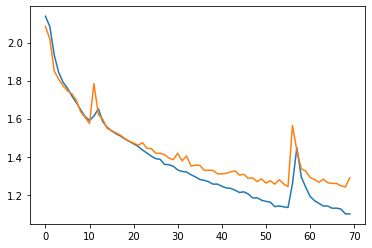

In [98]:
# visualize training/validation loss
plt.plot(trainer.loss_history[0])
plt.plot(trainer.loss_history[1])

# some forgetting, could rerun

In [99]:
# trainer.evaluate with testloader
prob, pred, true = trainer.evaluate(testloader)

In [100]:
from sklearn.metrics import classification_report

In [101]:
cr = classification_report(true, pred, target_names=ligands)

In [102]:
print(cr) # similar results to apeksha's model ~ 55% accuracy

              precision    recall  f1-score   support

         TNF       0.53      0.61      0.56      1528
         R84       0.66      0.73      0.69      1540
         PIC       0.58      0.56      0.57      1544
         P3K       0.54      0.53      0.53      1577
         FLA       0.42      0.38      0.40      1577
         CpG       0.38      0.45      0.41      1582
         FSL       0.36      0.20      0.26      1515
         LPS       0.43      0.47      0.45      1542
         UST       0.89      0.94      0.92      1503

    accuracy                           0.54     13908
   macro avg       0.53      0.54      0.53     13908
weighted avg       0.53      0.54      0.53     13908



In [106]:
fraction = Fraction(true, prob)

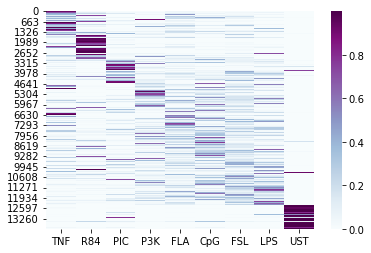

In [107]:
cf = sns.heatmap(fraction, cmap="BuPu", xticklabels=ligands)

## Polarization State Analysis

In [108]:
# refactor each polarization test_X and test_Y into torchdata object
# evaluate each one separately then concat and evaluate holistically

m0_test = TorchData(m0_test_X, m0_test_Y)
ib_test = TorchData(ib_test_X, ib_test_Y)
ig_test = TorchData(ig_test_X, ig_test_Y)
i0_test = TorchData(i0_test_X, i0_test_Y)
i3_test = TorchData(i3_test_X, i3_test_Y)
i4_test = TorchData(i4_test_X, i4_test_Y)

In [109]:
m0_loader = torch.utils.data.DataLoader(m0_test, batch_size=64, shuffle=True)
ib_loader = torch.utils.data.DataLoader(ib_test, batch_size=64, shuffle=True)
ig_loader = torch.utils.data.DataLoader(ig_test, batch_size=64, shuffle=True)
i0_loader = torch.utils.data.DataLoader(i0_test, batch_size=64, shuffle=True)
i3_loader = torch.utils.data.DataLoader(i3_test, batch_size=64, shuffle=True)
i4_loader = torch.utils.data.DataLoader(i4_test, batch_size=64, shuffle=True)

In [110]:
m0_prob, m0_pred, m0_true = trainer.evaluate(m0_loader)

In [111]:
ib_prob, ib_pred, ib_true = trainer.evaluate(ib_loader)

In [112]:
ig_prob, ig_pred, ig_true = trainer.evaluate(ig_loader)

In [113]:
i0_prob, i0_pred, i0_true = trainer.evaluate(i0_loader)

In [114]:
i3_prob, i3_pred, i3_true = trainer.evaluate(i3_loader)

In [115]:
i4_prob, i4_pred, i4_true = trainer.evaluate(i4_loader)

### M0

              precision    recall  f1-score      support
TNF            0.546429  0.581749  0.563536   263.000000
R84            0.598071  0.735178  0.659574   253.000000
PIC            0.759259  0.750916  0.755064   273.000000
P3K            0.448905  0.504098  0.474903   244.000000
FLA            0.475285  0.502008  0.488281   249.000000
CpG            0.382979  0.466667  0.420701   270.000000
FSL            0.425373  0.220077  0.290076   259.000000
LPS            0.495327  0.414062  0.451064   256.000000
UST            0.954733  0.924303  0.939271   251.000000
accuracy       0.566437  0.566437  0.566437     0.566437
macro avg      0.565151  0.566562  0.560275  2318.000000
weighted avg   0.565227  0.566437  0.560234  2318.000000


<AxesSubplot:>

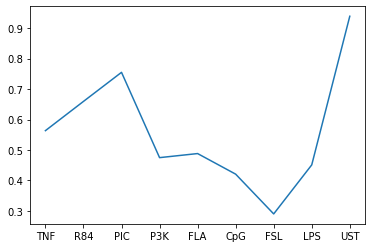

In [139]:
m0_cr = classification_report(m0_true, m0_pred, target_names=ligands, output_dict=True)
m0_crdf = pd.DataFrame(m0_cr).transpose()
print(m0_crdf)

m0_crdf[:9]['f1-score'].plot()

### ib

              precision    recall  f1-score      support
TNF            0.544402  0.532075  0.538168   265.000000
R84            0.706522  0.750000  0.727612   260.000000
PIC            0.552000  0.514925  0.532819   268.000000
P3K            0.651982  0.552239  0.597980   268.000000
FLA            0.493827  0.459770  0.476190   261.000000
CpG            0.416974  0.436293  0.426415   259.000000
FSL            0.451807  0.285171  0.349650   263.000000
LPS            0.345845  0.551282  0.425041   234.000000
UST            0.909091  0.958333  0.933063   240.000000
accuracy       0.556083  0.556083  0.556083     0.556083
macro avg      0.563606  0.560010  0.556326  2318.000000
weighted avg   0.563179  0.556083  0.554326  2318.000000


<AxesSubplot:>

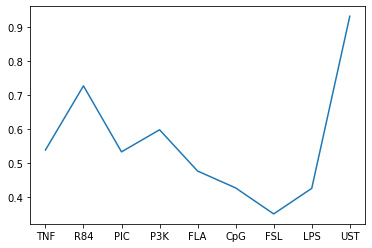

In [143]:
ib_cr = classification_report(ib_true, ib_pred, target_names=ligands, output_dict=True)
ib_crdf = pd.DataFrame(ib_cr).transpose()
print(ib_crdf)

ib_crdf[:9]['f1-score'].plot()

### ig

              precision    recall  f1-score     support
TNF            0.600746  0.631373  0.615679   255.00000
R84            0.670139  0.736641  0.701818   262.00000
PIC            0.583815  0.400794  0.475294   252.00000
P3K            0.465409  0.550186  0.504259   269.00000
FLA            0.340426  0.252964  0.290249   253.00000
CpG            0.297619  0.288462  0.292969   260.00000
FSL            0.192308  0.138340  0.160920   253.00000
LPS            0.383663  0.593870  0.466165   261.00000
UST            0.955102  0.924901  0.939759   253.00000
accuracy       0.503020  0.503020  0.503020     0.50302
macro avg      0.498803  0.501948  0.494124  2318.00000
weighted avg   0.498284  0.503020  0.494409  2318.00000


<AxesSubplot:>

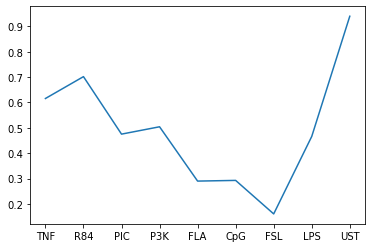

In [144]:
ig_cr = classification_report(ig_true, ig_pred, target_names=ligands, output_dict=True)
ig_crdf = pd.DataFrame(ig_cr).transpose()
print(ig_crdf)

ig_crdf[:9]['f1-score'].plot()

### i0

              precision    recall  f1-score      support
TNF            0.529231  0.674510  0.593103   255.000000
R84            0.612795  0.755187  0.676580   241.000000
PIC            0.609959  0.588000  0.598778   250.000000
P3K            0.441558  0.404762  0.422360   252.000000
FLA            0.340081  0.286689  0.311111   293.000000
CpG            0.340361  0.457490  0.390328   247.000000
FSL            0.338983  0.241935  0.282353   248.000000
LPS            0.443925  0.340502  0.385396   279.000000
UST            0.952756  0.956522  0.954635   253.000000
accuracy       0.516393  0.516393  0.516393     0.516393
macro avg      0.512183  0.522844  0.512738  2318.000000
weighted avg   0.508664  0.516393  0.507793  2318.000000


<AxesSubplot:>

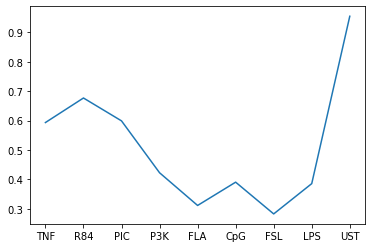

In [140]:
i0_cr = classification_report(i0_true, i0_pred, target_names=ligands, output_dict=True)
i0_crdf = pd.DataFrame(i0_cr).transpose()
print(i0_crdf)

i0_crdf[:9]['f1-score'].plot()

### i3

              precision    recall  f1-score      support
TNF            0.463492  0.605809  0.525180   241.000000
R84            0.638629  0.770677  0.698467   266.000000
PIC            0.540541  0.564516  0.552268   248.000000
P3K            0.598291  0.500000  0.544747   280.000000
FLA            0.415966  0.373585  0.393638   265.000000
CpG            0.394410  0.437931  0.415033   290.000000
FSL            0.362832  0.165992  0.227778   247.000000
LPS            0.489796  0.493827  0.491803   243.000000
UST            0.822878  0.936975  0.876228   238.000000
accuracy       0.535375  0.535375  0.535375     0.535375
macro avg      0.525204  0.538812  0.525016  2318.000000
weighted avg   0.522971  0.535375  0.522363  2318.000000


<AxesSubplot:>

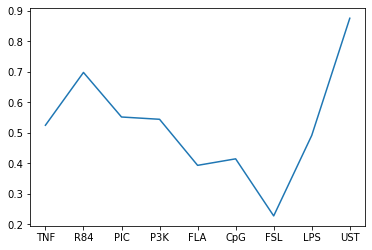

In [141]:
i3_cr = classification_report(i3_true, i3_pred, target_names=ligands, output_dict=True)
i3_crdf = pd.DataFrame(i3_cr).transpose()
print(i3_crdf)

i3_crdf[:9]['f1-score'].plot()

### i4

              precision    recall  f1-score      support
TNF            0.493671  0.626506  0.552212   249.000000
R84            0.783920  0.604651  0.682713   258.000000
PIC            0.438871  0.553360  0.489510   253.000000
P3K            0.643123  0.655303  0.649156   264.000000
FLA            0.433333  0.406250  0.419355   256.000000
CpG            0.441176  0.585938  0.503356   256.000000
FSL            0.447059  0.155102  0.230303   245.000000
LPS            0.502128  0.438662  0.468254   269.000000
UST            0.793651  0.932836  0.857633   268.000000
accuracy       0.554357  0.554357  0.554357     0.554357
macro avg      0.552992  0.550956  0.539166  2318.000000
weighted avg   0.555293  0.554357  0.542411  2318.000000


<AxesSubplot:>

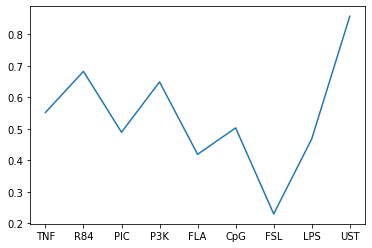

In [142]:
i4_cr = classification_report(i4_true, i4_pred, target_names=ligands, output_dict=True)
i4_crdf = pd.DataFrame(i4_cr).transpose()
print(i4_crdf)

i4_crdf[:9]['f1-score'].plot()

## Holistic

In [149]:
total_f1 = pd.concat([m0_crdf['f1-score'], ib_crdf['f1-score'], ig_crdf['f1-score'], i0_crdf['f1-score'], i3_crdf['f1-score'], i4_crdf['f1-score']], axis=1)
total_f1 = total_f1.set_axis(['M0', 'IB', 'IG', 'I0', 'I3', 'I4'], axis=1)

In [154]:
total_f1.iloc[:9]

,M0,IB,IG,I0,I3,I4
TNF,0.563536,0.538168,0.615679,0.593103,0.525180,0.552212
R84,0.659574,0.727612,0.701818,0.676580,0.698467,0.682713
PIC,0.755064,0.532819,0.475294,0.598778,0.552268,0.489510
P3K,0.474903,0.597980,0.504259,0.422360,0.544747,0.649156
FLA,0.488281,0.476190,0.290249,0.311111,0.393638,0.419355
CpG,0.420701,0.426415,0.292969,0.390328,0.415033,0.503356
FSL,0.290076,0.349650,0.160920,0.282353,0.227778,0.230303
LPS,0.451064,0.425041,0.466165,0.385396,0.491803,0.468254
UST,0.939271,0.933063,0.939759,0.954635,0.876228,0.857633


<AxesSubplot:>

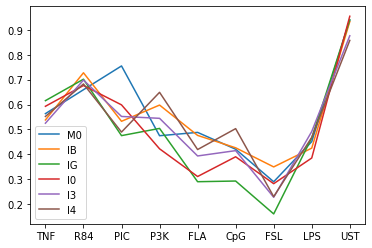

In [156]:
total_f1.iloc[:9].plot()

<AxesSubplot:>

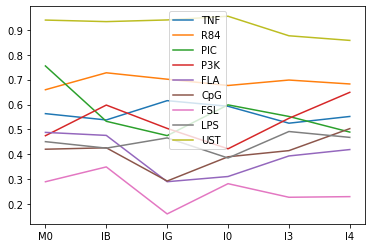

In [157]:
total_f1.iloc[:9].transpose().plot()

In [161]:
# average f1 score for all ligands across each polarization state
np.mean(total_f1.iloc[:9])

M0    0.560275
IB    0.556326
IG    0.494124
I0    0.512738
I3    0.525016
I4    0.539166
dtype: float64

<AxesSubplot:>

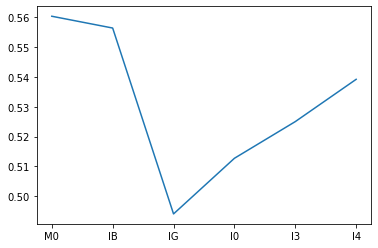

In [162]:
np.mean(total_f1.iloc[:9]).plot()